# 2023-05-15

## 전체 시퀀스 구현

In [1]:
# 0. 필요한 모듈 로드

import tensorflow
from tensorflow.keras.models import load_model

In [8]:
input_video_path = './data/total_0513/4_test_data/test_video03.mov'
split_video_path = './testing/3_video/output_segment'


# 1. full video를 5개로 분할하여 경로(split_video_path)에 저장한다.
video_split(input_video_path, split_video_path, 5)
print('1번 완료')

# 2. 각 동영상을 15장의 이미지셋으로 변환하여 어레이로 저장한다.(images_list00, images_list01, ..., images_list04)
for i in range(5):
    video_path = f'./testing/3_video/output_segment_{i+1}.mp4'
    globals()[f'images_list0{i}'] = video_to_images(15, video_path)
print('2번 완료')

# 3. 이미지에서 스켈레톤 좌표를 추출하여 df로 저장한다.(df00, df01, df02, df03, df04, shape = (15, 22))
for n in range(5):
    total_skeleton = []
    for j in range(15):
        temp_img = img_to_skeleton(globals()[f'images_list0{n}'][j])
        total_skeleton.append(temp_img) # 여기서 스켈레톤 추출
    df = pd.DataFrame()
    for i in range(len(total_skeleton)):
        temp = np.array(total_skeleton[i])
        temp = temp.flatten()
        df[i] = temp
    globals()[f'df0{n}'] = df.T
print('3번 완료')

# 4. 모델 인풋에 맞게 shape을 조정한다. inputs shape = (5,22), outputs shape = (5, 308)
inputs, outputs = shape_control(df00, df01, df02, df03, df04)
print('4번 완료')

# 5. 모델 예측 실행하여 pred에 저장한다. pred.shape = (5, 308)
model = load_model('./learned_models/model_0517_113_ver1.h5')
pred = model.predict(inputs)
print('5번 완료')

# 6. pred와 ture를 비교하여 mse를 계산하고 best, worst rep을 반환한다.
lst_loss = []
for i in range(len(pred)):
    loss = str(mse_loss(outputs[i], pred[i]))[10:30]
    lst_loss.append(loss) 
best = min(lst_loss)
worst = max(lst_loss)
print('6번 완료\n')
print(f'best reps : {lst_loss.index(best)+1}번째 영상')
print(f'worst reps : {lst_loss.index(worst)+1}번째 영상')

# 7. best, worst reps에 대한 동영상 보여주기
# print(f'best reps path = {split_video_path} + ')

# 8. 운동에 대한 피드백을 보여준다.

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1번 완료
2번 완료


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


3번 완료
4번 완료
Metal device set to: Apple M2 Pro
1/1 [==============================] - 0s 133ms/step
5번 완료
6번 완료

best reps : 1번째 영상
worst reps : 4번째 영상


2023-05-22 15:53:25.276984: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
lst_loss # 다솔 스쿼트

['0.001671776931575645',
 '0.00298760962773411,',
 '0.003954986799893151',
 '0.004592573688711216',
 '0.003300925132579390']

In [2]:
# 1. full video를 5개로 분할하여 경로(split_video_path)에 저장한다.

import cv2

def video_split(input_file, output_prefix, segment_count):
    # 동영상 파일 열기
    cap = cv2.VideoCapture(input_file)

    # 동영상 속성 가져오기
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # 세그먼트 길이 계산
    segment_length_frames = total_frames // segment_count

    # 저장할 세그먼트 번호 초기화
    segment_number = 1

    frame_count = 0
    while segment_number <= segment_count:
        # 동영상의 현재 프레임 설정
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

        # 세그먼트 파일 이름 설정
        output_file = f"{output_prefix}_{segment_number}.mp4"

        # 세그먼트 파일 생성
        out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

        # 세그먼트 길이만큼 프레임 저장
        for i in range(segment_length_frames):
            # 동영상의 현재 프레임 읽기
            ret, frame = cap.read()

            # 프레임 저장
            out.write(frame)

        # 세그먼트 파일 닫기
        out.release()

        # 다음 세그먼트 번호로 이동
        segment_number += 1

        # 다음 세그먼트의 시작 프레임 설정
        frame_count += segment_length_frames

    # 동영상 파일 닫기
    cap.release()

In [3]:
# 2. 각 동영상을 15장의 이미지셋으로 변환하여 어레이로 저장한다.

import cv2
import os
import numpy as np

def video_to_images(N, video_PATH) :
    
    # 1. 동영상의 모든 프레임을 리스트(temp_list)에 저장하기
    temp_list = []
    video = cv2.VideoCapture(video_PATH)
    fps = video.get(cv2.CAP_PROP_FPS)
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break

        if ret:
            temp_list.append(frame)

    video.release()
    
    # 2. 건너 뛸 간격(skip)을 계산해서 넘파이 어레이로 저장하기
    images_list = []
    skip = len(temp_list) / N
    cnt = 0
    for i in range(len(temp_list)):
        if i == np.floor(skip*cnt):
            images_list.append(temp_list[i])
            cnt += 1
    images_array = np.array(images_list)
    
    return images_array

In [4]:
# 3. 이미지에서 스켈레톤 좌표를 추출하여 df로 저장한다.(df00, df01, df02, df03, df04, shape = (15, 22))

import mediapipe as mp
import cv2
import os
import pandas as pd

def img_to_skeleton(img_array):
    
    # 모듈 로드
    mp_pose = mp.solutions.pose
    
    # 이미지에서 프레임을 읽어온다.
    image = img_array
    
    # HumanPose 모듈을 사용하여 스켈레톤을 추출한다.
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:
        
        # 추출된 스켈레톤을 저장할 리스트를 생성한다.
        landmarks_list = []
        
        # 스켈레톤을 추출한다.
        results = pose.process(image)
        landmark = results.pose_landmarks.landmark
        
        if len(landmark) == 33: # 33보다 적거나 많다는 것은 잘못된 추출이다.
            
            # 필요한 관절 좌표만 선별적으로 저장한다.
            need = [0, 11, 12, 23, 24, 25, 26, 27, 28, 31, 32]
            for i in need:
                # 스켈레톤의 좌표를 저장한다.
                x = round(landmark[i].x, 5)
                y = round(landmark[i].y, 5)
                landmarks_list.append((x, y)) # x,y좌표만 저장한다.
                
        else:
            return 'There is a problem.'
        
    return landmarks_list

objc[1043]: Class CaptureDelegate is implemented in both /Users/estar-kim/miniconda3/envs/tfgpu2/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x29a96a5a0) and /Users/estar-kim/miniconda3/envs/tfgpu2/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x29d118860). One of the two will be used. Which one is undefined.
objc[1043]: Class CVWindow is implemented in both /Users/estar-kim/miniconda3/envs/tfgpu2/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x29a96a5f0) and /Users/estar-kim/miniconda3/envs/tfgpu2/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x294ac0a68). One of the two will be used. Which one is undefined.
objc[1043]: Class CVView is implemented in both /Users/estar-kim/miniconda3/envs/tfgpu2/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x29a96a618) and /Users/estar-kim/miniconda3/envs/tfgpu2/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x294ac0a90). One of the two will be used. Wh

In [5]:
# 4. 모델 인풋에 맞게 shape을 조정한다. inputs shape = (5,22), outputs shape = (5, 308)

def shape_control(df00, df01, df02, df03, df04):
    arrX = []
    arrY = []

    for i in range(5):
        tempX = globals()[f'df0{i}'].iloc[0]
        tempY = globals()[f'df0{i}'].iloc[1:]
        tempX = np.array(tempX)
        tempY = np.array(tempY)
        tempY = tempY.flatten() # 일차원 넘파이 배열로 변경
        arrX.append(tempX)
        arrY.append(tempY)

    inputs = np.array(arrX)
    outputs = np.array(arrY)

#     print(f'inputs.shape = {inputs.shape}, outputs.shape = {outputs.shape}')
    return inputs, outputs

In [6]:
# 6. mse 계산 함수

import tensorflow as tf

# mse 계산

def mse_loss(y_true, y_pred):
    err = y_true - y_pred
    loss = tf.math.reduce_mean(tf.math.square(err))

    return loss

In [8]:
input_video_path = './data/total_0513/4_test_data/test_video01.mov'
split_video_path = './testing/1_video/output_segment'


# 1. full video를 5개로 분할하여 경로(split_video_path)에 저장한다.
video_split(input_video_path, split_video_path, 5)
print('1번 완료')

# 2. 각 동영상을 15장의 이미지셋으로 변환하여 어레이로 저장한다.(images_list00, images_list01, ..., images_list04)
for i in range(5):
    video_path = f'./testing/1_video/output_segment_{i+1}.mp4'
    globals()[f'images_list0{i}'] = video_to_images(15, video_path)
print('2번 완료')

# 3. 이미지에서 스켈레톤 좌표를 추출하여 df로 저장한다.(df00, df01, df02, df03, df04, shape = (15, 22))
for n in range(5):
    total_skeleton = []
    for j in range(15):
        temp_img = img_to_skeleton(globals()[f'images_list0{n}'][j])
        total_skeleton.append(temp_img) # 여기서 스켈레톤 추출
    df = pd.DataFrame()
    for i in range(len(total_skeleton)):
        temp = np.array(total_skeleton[i])
        temp = temp.flatten()
        df[i] = temp
    globals()[f'df0{n}'] = df.T
print('3번 완료')

# 4. 모델 인풋에 맞게 shape을 조정한다. inputs shape = (5,22), outputs shape = (5, 308)
inputs, outputs = shape_control(df00, df01, df02, df03, df04)
print('4번 완료')

# 5. 모델 예측 실행하여 pred에 저장한다. pred.shape = (5, 308)
model = load_model('./learned_models/model_0517_113_ver1.h5')
pred = model.predict(inputs)
print('5번 완료')

# 6. pred와 ture를 비교하여 mse를 계산하고 best, worst rep을 반환한다.
lst_loss = []
for i in range(len(pred)):
    loss = str(mse_loss(outputs[i], pred[i]))[10:30]
    lst_loss.append(loss) 
best = min(lst_loss)
worst = max(lst_loss)
print('6번 완료\n')
print(f'best reps : {lst_loss.index(best)+1}번째 영상')
print(f'worst reps : {lst_loss.index(worst)+1}번째 영상')

# 7. best, worst reps에 대한 동영상 보여주기
# print(f'best reps path = {split_video_path} + ')


# 8. 운동에 대한 피드백을 보여준다.

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1번 완료
2번 완료
3번 완료
4번 완료
Metal device set to: Apple M2 Pro
1/1 [==============================] - 0s 71ms/step
5번 완료
6번 완료

best reps : 2번째 영상
worst reps : 4번째 영상


2023-05-22 01:52:34.247767: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
# 김은성 스쿼트 영상
lst_loss

['0.000861725359677880',
 '0.000712028704872278',
 '0.001091081371595408',
 '0.001611983767425861',
 '0.000843242250506719']

In [7]:
# 앞서 구한 은비 언니 스쿼트 mse
eunbi_loss = ['0.002810457367870134',
 '0.003266279492103828',
 '0.00414068777905038,',
 '0.003821817170403501',
 '0.002586389829274401']

In [15]:
outputs[0].shape

(308,)

In [12]:
pred[0].shape

(308,)

In [34]:
i = 3

temp_pred = pred[i].reshape((14, 11, 2))
temp_y_test = outputs[i].reshape((14, 11, 2))
# temp_y_test = np.array(df000[1:]).reshape((14, 11, 2))

print(f'temp_pred shape {temp_pred.shape}')
print(f'temp_y_test shape {temp_y_test.shape}')

temp_pred shape (14, 11, 2)
temp_y_test shape (14, 11, 2)


In [35]:
temp_pred[7]

array([[0.48741806, 0.46106   ],
       [0.6244384 , 0.532196  ],
       [0.37077808, 0.54371333],
       [0.58676445, 0.6975385 ],
       [0.42035657, 0.6995067 ],
       [0.72865   , 0.7160701 ],
       [0.26505345, 0.72675043],
       [0.6812211 , 0.85986483],
       [0.307018  , 0.861493  ],
       [0.7510716 , 0.9030362 ],
       [0.25468072, 0.9088479 ]], dtype=float32)

In [36]:
temp_y_test[7]

array([[0.48838, 0.39386],
       [0.63181, 0.47735],
       [0.34261, 0.47658],
       [0.58747, 0.66377],
       [0.41138, 0.66381],
       [0.78871, 0.72429],
       [0.21774, 0.73427],
       [0.69492, 0.87154],
       [0.33033, 0.86824],
       [0.78186, 0.94339],
       [0.25665, 0.93774]])

blut : true(outputs), red : pred


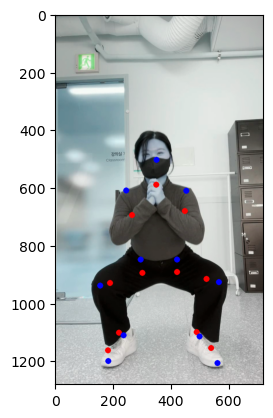

In [37]:
import matplotlib.pyplot as plt

# img = cv2.imread(f'./data/total_0513/2_2_images/{number}/exercise_08.jpg')
img = images_list02[8]
# background = np.zeros(shape=img.shape, dtype=np.uint8) + 255

# pred 좌표
for i in temp_pred[7]:
    cx = int(i[0]*img.shape[1])
    cy = int(i[1]*img.shape[0])
    cv2.circle(img, (cx, cy), radius=5, color=(255,0,0), thickness=10)
    
# y_test 좌표
for i in temp_y_test[7]:
    cx = int(i[0]*img.shape[1])
    cy = int(i[1]*img.shape[0])
    cv2.circle(img, (cx, cy), radius=5, color=(0,0,255), thickness=10)
    
print('blut : true(outputs), red : pred')

plt.imshow(img)
plt.show()

In [25]:
images_list00[8].shape

(1280, 720, 3)

In [42]:
# 은비 언니 데이터로 확인
i = 4

temp_pred = pred[i].reshape((14, 11, 2))
temp_y_test = outputs[i].reshape((14, 11, 2))
# temp_y_test = np.array(df000[1:]).reshape((14, 11, 2))

print(f'temp_pred shape {temp_pred.shape}')
print(f'temp_y_test shape {temp_y_test.shape}')

temp_pred shape (14, 11, 2)
temp_y_test shape (14, 11, 2)


blut : true(outputs), red : pred


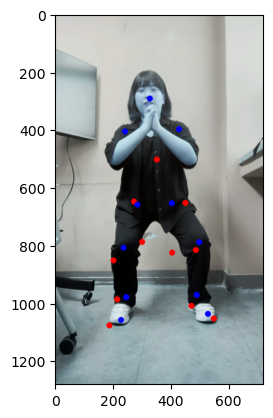

In [43]:
import matplotlib.pyplot as plt

# img = cv2.imread(f'./data/total_0513/2_2_images/{number}/exercise_08.jpg')
img = images_list04[8]
# background = np.zeros(shape=img.shape, dtype=np.uint8) + 255

# pred 좌표
for i in temp_pred[7]:
    cx = int(i[0]*img.shape[1])
    cy = int(i[1]*img.shape[0])
    cv2.circle(img, (cx, cy), radius=5, color=(255,0,0), thickness=10)
    
# y_test 좌표
for i in temp_y_test[7]:
    cx = int(i[0]*img.shape[1])
    cy = int(i[1]*img.shape[0])
    cv2.circle(img, (cx, cy), radius=5, color=(0,0,255), thickness=10)
    
print('blut : true(outputs), red : pred')

plt.imshow(img)
plt.show()

In [21]:
# 다솔 언니 데이터로 확인
i = 2

temp_pred = pred[i].reshape((14, 11, 2))
temp_y_test = outputs[i].reshape((14, 11, 2))
# temp_y_test = np.array(df000[1:]).reshape((14, 11, 2))

print(f'temp_pred shape {temp_pred.shape}')
print(f'temp_y_test shape {temp_y_test.shape}')

temp_pred shape (14, 11, 2)
temp_y_test shape (14, 11, 2)


blut : true(outputs), red : pred


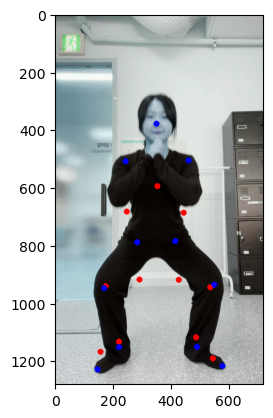

In [23]:
import matplotlib.pyplot as plt

img = images_list02[8]

# pred 좌표
for i in temp_pred[7]:
    cx = int(i[0]*img.shape[1])
    cy = int(i[1]*img.shape[0])
    cv2.circle(img, (cx, cy), radius=5, color=(255,0,0), thickness=10)
    
# y_test 좌표
for i in temp_y_test[7]:
    cx = int(i[0]*img.shape[1])
    cy = int(i[1]*img.shape[0])
    cv2.circle(img, (cx, cy), radius=5, color=(0,0,255), thickness=10)
    
print('blut : true(outputs), red : pred')

plt.imshow(img)
plt.show()

### 처음 시작 자세가 모델 예측에 있어 상당이 중요함. 따라서 이는 사전에 코칭을 좀 해줘야 할듯..

In [45]:
temp_pred[7] - temp_y_test[7]

array([[ 0.0341688 ,  0.16537772],
       [ 0.03051872,  0.19944391],
       [ 0.04300598,  0.18892993],
       [ 0.00063576,  0.13380474],
       [ 0.02162908,  0.10068572],
       [-0.01689664,  0.02173489],
       [-0.04928373,  0.03406472],
       [-0.025096  ,  0.02966557],
       [-0.04276218,  0.00552677],
       [ 0.02767389,  0.01252344],
       [-0.05604925,  0.01479472]])